In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# In this notebook, we will be exploring a dataset containing information about individual patients, including their age, sex, body mass index (BMI), number of children, smoking status, and region. Our goal is to use this information to predict the amount of money a patient will spend on hospital charges. We will start by performing exploratory data analysis (EDA) to understand the distribution of the data and identify any patterns or trends. Next, we will preprocess the data to prepare it for modeling. We will then use linear regression to build a model to predict hospital charges.

# __Contents__: <br>1.Data Inspection & Analysis <br>2.Outliers Detection & Handling <br>3.Correlation <br>4.Linear Regression for Charges Prediction: <br>-Model 1 - only with Age variable <br>-Model 2 - with Transformation <br>-Model 3 - adding Dummy variable "Smoker" <br>-Model 4 - adding Dummy variable "Sex"

# 1.Data Inspection & Analysis

In [2]:
data = pd.read_csv("medical_insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.shape

(1338, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# Replace all blank spaces in columns' names
data.columns = data.columns.str.replace(' ', '')

In [6]:
# Replace all blank spaces in a dataframe
data_obj = data.select_dtypes(['object'])
data[data_obj.columns] = data_obj.apply(lambda x: x.str.strip())
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
# Check for Null values
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


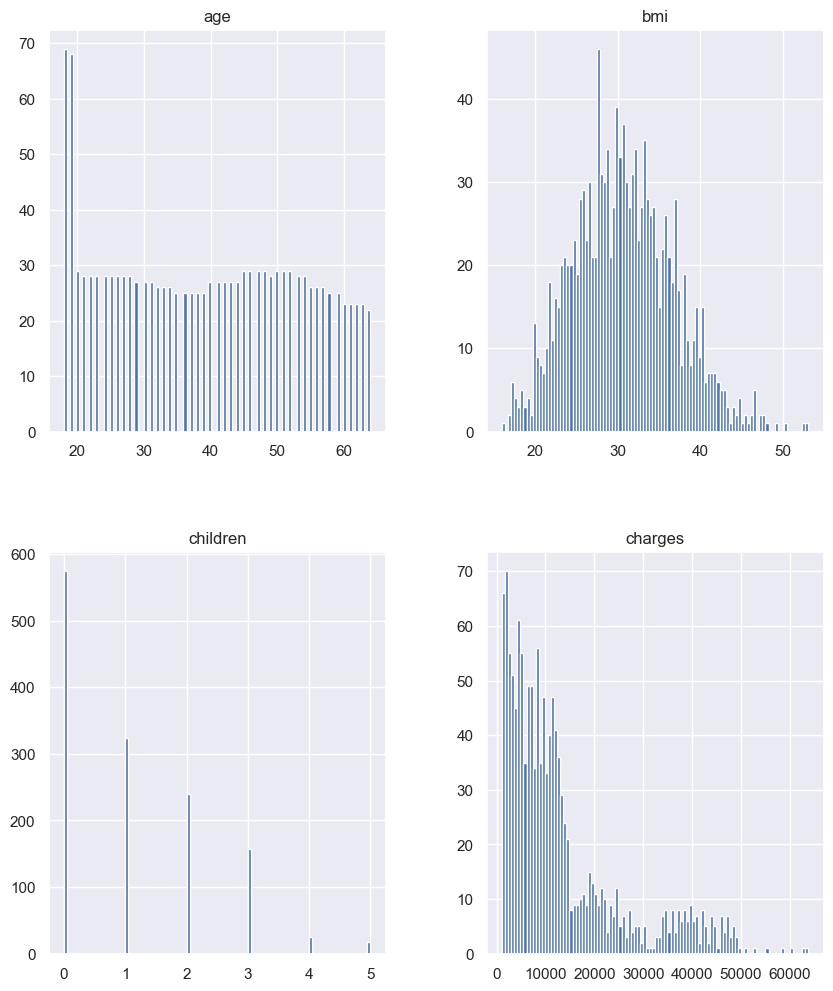

In [9]:
# Create histograms
sns.set()
data.hist(figsize = (10,12), bins = 100)
plt.show()

In [10]:
data.describe(include = 'object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


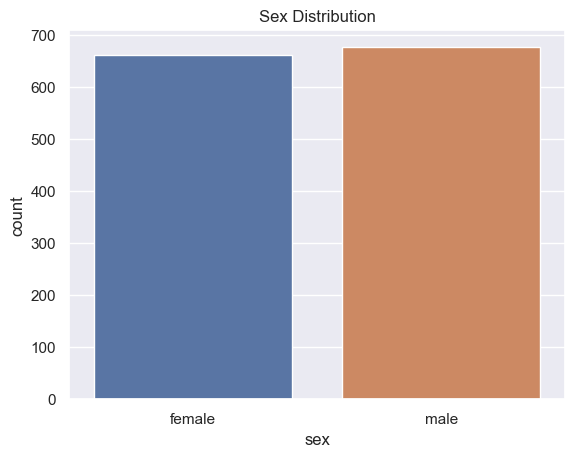

In [11]:
# Sex Distribution
sns.set()
sns.countplot(x = 'sex', data = data)
plt.title('Sex Distribution')
plt.show()

In [12]:
data['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

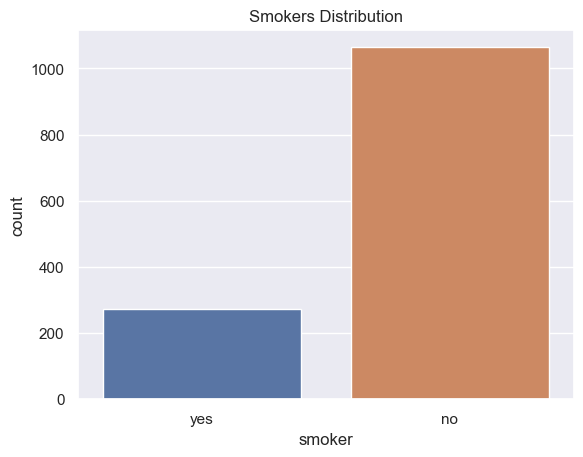

In [13]:
# Smokers Distribution
sns.set()
sns.countplot(x = 'smoker', data = data)
plt.title('Smokers Distribution')
plt.show()

In [14]:
data['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

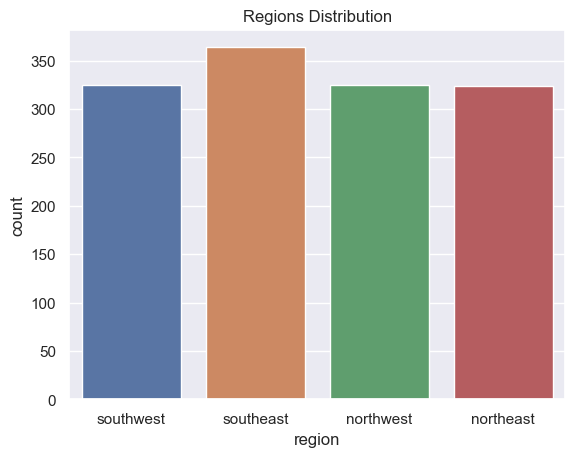

In [15]:
# Region Distribution
sns.set()
sns.countplot(x = 'region', data = data)
plt.title('Regions Distribution')
plt.show()

In [16]:
data['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

# 2.Outliers Detection & Handling

In [17]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


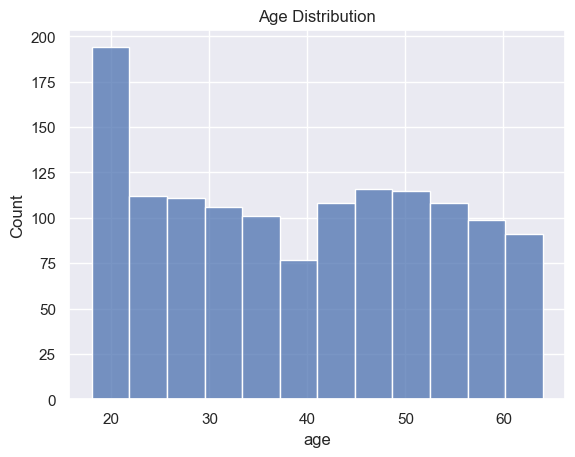

In [18]:
# Age Distribution
sns.histplot(data['age'])
plt.title('Age Distribution')
plt.show()

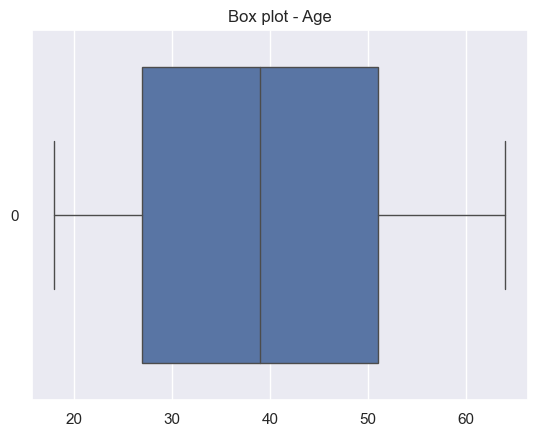

In [19]:
sns.boxplot(data['age'], orient='h', linewidth= 1)
plt.title('Box plot - Age')
plt.show()

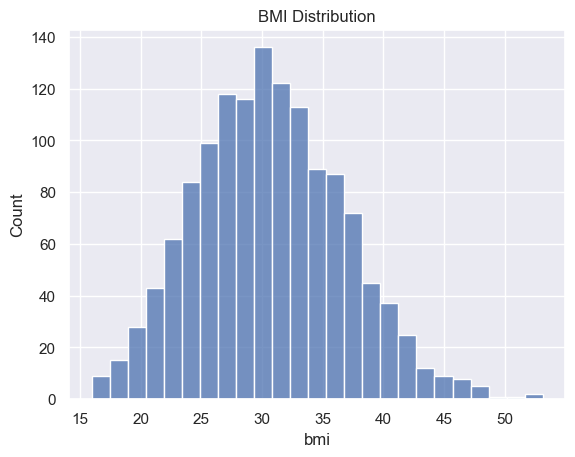

In [20]:
# BMI Distribution
sns.histplot(data['bmi'])
plt.title('BMI Distribution')
plt.show()

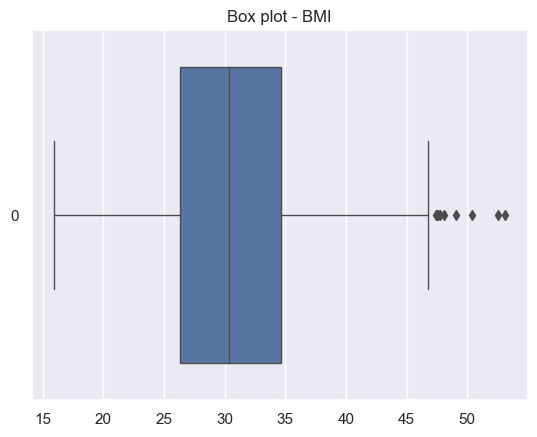

In [21]:
sns.boxplot(data['bmi'], orient='h', linewidth= 1)
plt.title('Box plot - BMI')
plt.show()

In [22]:
# Sort values for Outliers Detection
bmi_dsc = data.bmi.sort_values(ascending = False)
bmi_dsc.head(50)

1317    53.130
1047    52.580
847     50.380
116     49.060
286     48.070
1088    47.740
860     47.600
401     47.520
543     47.410
438     46.750
547     46.700
454     46.530
930     46.530
660     46.530
549     46.200
941     46.090
1131    45.900
292     45.540
582     45.430
1024    45.320
1156    44.880
563     44.770
701     44.745
1332    44.700
796     44.220
521     44.220
895     44.000
356     43.890
674     43.890
867     43.700
493     43.400
383     43.340
572     43.120
442     43.010
811     42.940
1312    42.900
951     42.900
1124    42.750
650     42.680
1067    42.655
627     42.460
656     42.400
640     42.400
265     42.350
803     42.240
1161    42.130
1239    42.130
14      42.130
530     42.130
227     41.910
Name: bmi, dtype: float64

In [23]:
index_outliers = data.loc[data.bmi > 51].index
index_outliers

Int64Index([1047, 1317], dtype='int64')

In [24]:
data.loc[data.bmi > 51, 'bmi'] = 50
data.loc[index_outliers]

,age,sex,bmi,children,smoker,region,charges
1047,22,male,50.0,1,yes,southeast,44501.3982
1317,18,male,50.0,0,no,southeast,1163.4627


# 3.Correlation

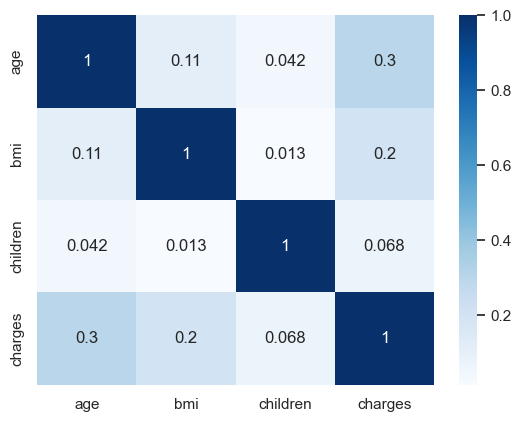

In [25]:
# Correlation coefficients
corr = data.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

__There is no correlation between independent variables. <br>There is no strong correlation between any independent
variable and dependent variable (charges).__

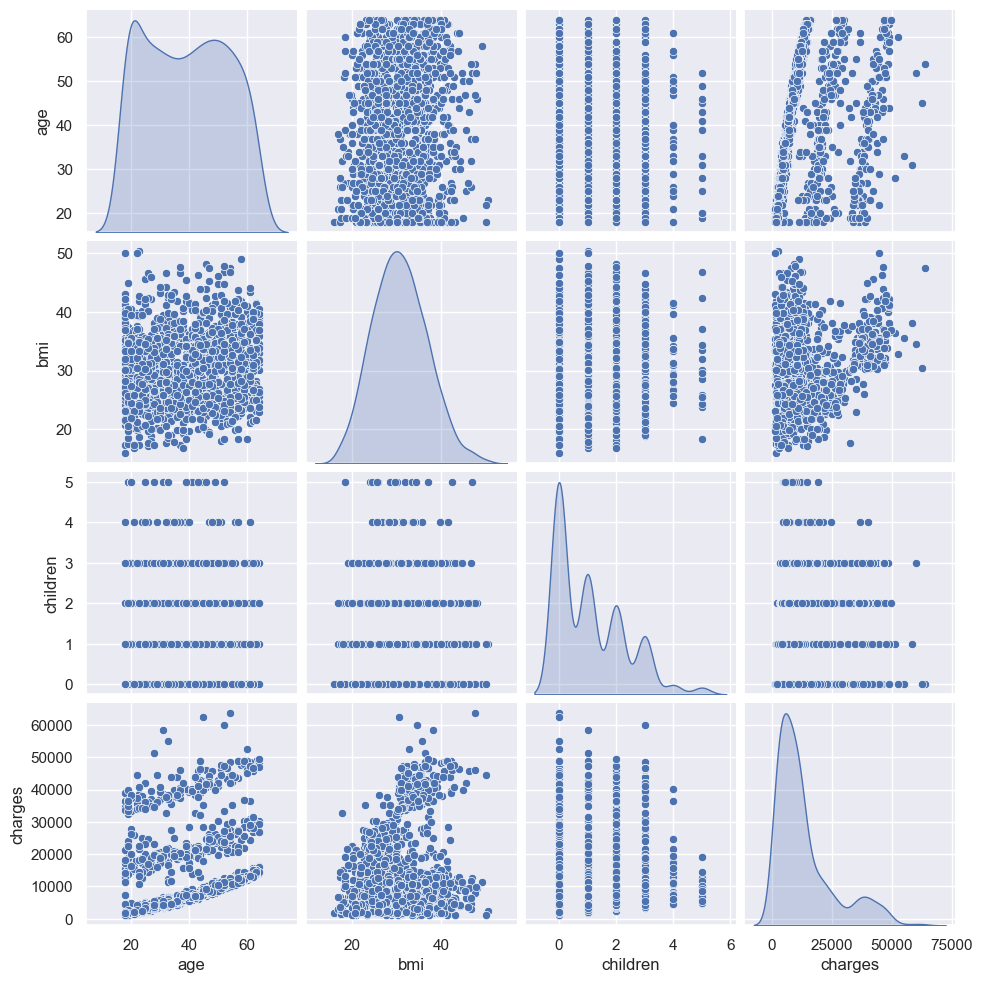

In [26]:
g = sns.pairplot(data,diag_kind='kde')
g.fig.set_size_inches(10,10)

__There is low correlation between variables 'age' and 'charges', and R is equal to 0.3.__

# 4.Linear Regression for Charges prediction

In [27]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Scatter plots - checking for correlation 

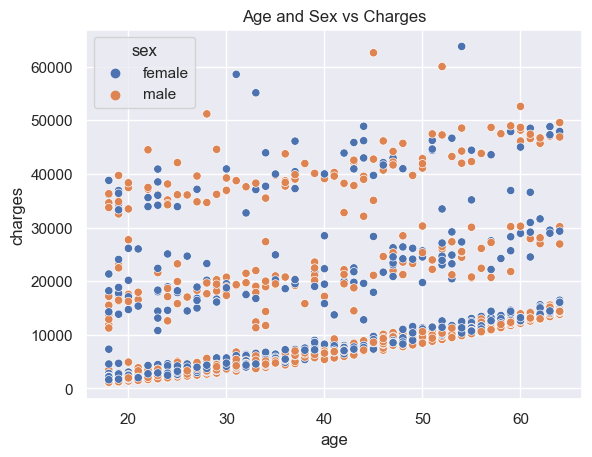

In [28]:
sns.scatterplot(data, x = 'age', y = 'charges', hue = 'sex')
plt.title('Age and Sex vs Charges')
plt.show()

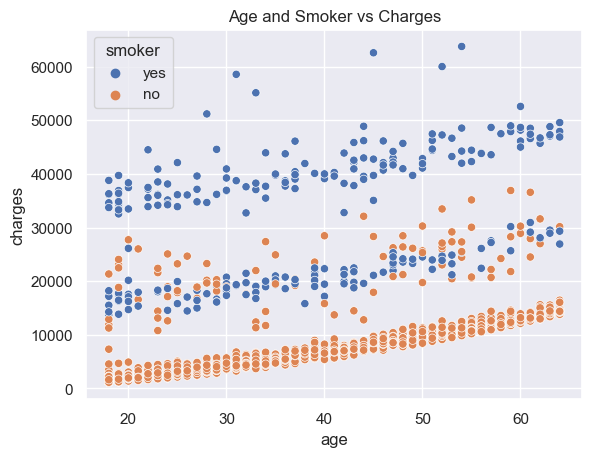

In [29]:
sns.scatterplot(data, x = 'age', y = 'charges', hue = 'smoker')
plt.title('Age and Smoker vs Charges')
plt.show()

__The plot shows that people in lower ages and non smokers have lower charges.__

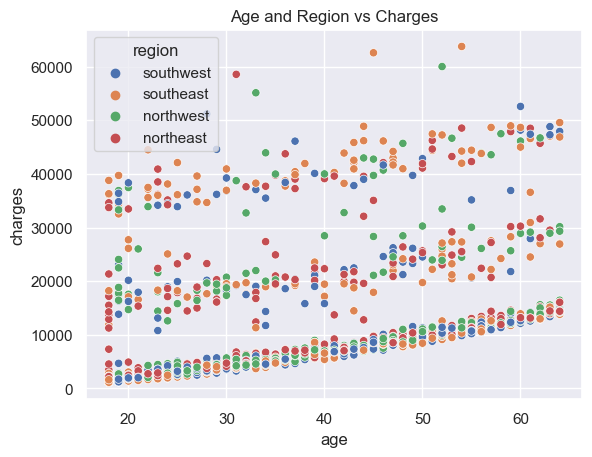

In [30]:
sns.scatterplot(data, x = 'age', y = 'charges', hue = 'region')
plt.title('Age and Region vs Charges')
plt.show()

## Model 1 - only with age variable

In [31]:
x = data['age']
y = data['charges']
x2 = sm.add_constant(x)
model = sm.OLS(y, x2)
Model = model.fit()
print(Model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           4.89e-29
Time:                        19:45:48   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.8850    937.149      3.378      0.0

__R_squared = 0.089 <br> Adj. R-squared = 0.089 <br> Prob (F-statistic) = 4.89e-29__

In [32]:
E = Model.resid_pearson
E

array([ 0.76315515, -0.5258804 , -0.51319185, ..., -0.53416035,
       -0.56833386,  0.88703474])

In [33]:
yhat = Model.predict(x2)
yhat

0        8062.614761
1        7804.892142
2       10382.118329
3       11670.731422
4       11413.008803
            ...     
1333    16052.015939
1334     7804.892142
1335     7804.892142
1336     8578.059998
1337    18886.964745
Length: 1338, dtype: float64

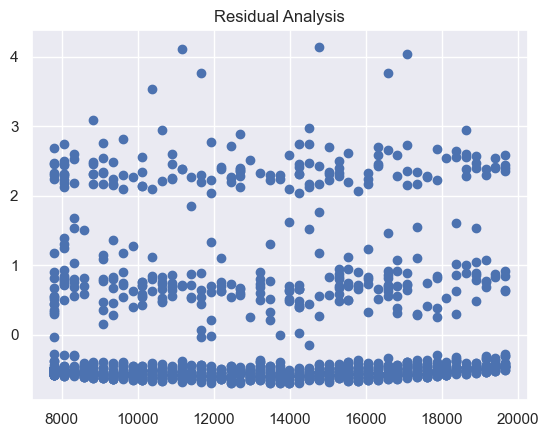

In [34]:
plt.scatter(yhat,E)
plt.title('Residual Analysis')
plt.show()

__The model is invalid or there is another variable to predict charges.__

## Model 2 - with Transformation

In [35]:
# Transformation
Y = np.log(y)
Y

0        9.734176
1        7.453302
2        8.400538
3        9.998092
4        8.260197
          ...    
1333     9.268661
1334     7.698927
1335     7.396233
1336     7.604867
1337    10.279914
Name: charges, Length: 1338, dtype: float64

In [36]:
model2 = sm.OLS(Y,x2)
Model2 = model2.fit()
print(Model2.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     516.0
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           7.48e-97
Time:                        19:45:48   Log-Likelihood:                -1567.3
No. Observations:                1338   AIC:                             3139.
Df Residuals:                    1336   BIC:                             3149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7442      0.063    122.272      0.0

__R_squared = 0.279 <br> Adj. R-squared = 0.278 <br> Prob (F-statistic) = 7.48e-97__

In [37]:
E2 = Model2.resid_pearson
E2

array([ 1.70688414, -1.16826844, -0.39802375, ..., -1.24131338,
       -1.10692217,  0.54834146])

In [38]:
yhat = Model2.predict(x2)
yhat

0       8.400604
1       8.366059
2       8.711511
3       8.884236
4       8.849691
          ...   
1333    9.471503
1334    8.366059
1335    8.366059
1336    8.469695
1337    9.851500
Length: 1338, dtype: float64

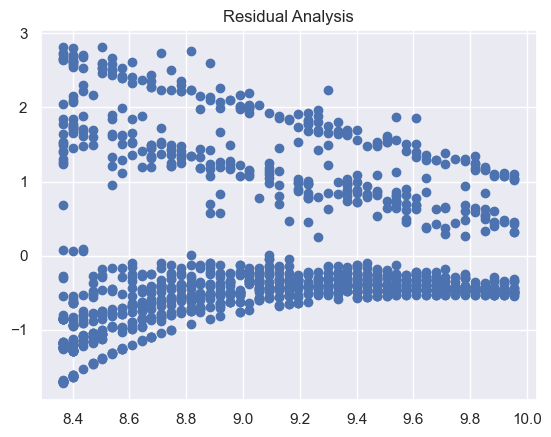

In [39]:
plt.scatter(yhat,E2)
plt.title('Residual Analysis')
plt.show()

__The model is not valid or there is another variable to predict charges.__

## Model 3 - adding dummy variable "Smoker"

In [40]:
just_dummies = pd.get_dummies(data['smoker'])
step_1 = pd.concat([data, just_dummies], axis = 1)
step_1

,age,sex,bmi,children,smoker,region,charges,no,yes
0,19,female,27.900,0,yes,southwest,16884.92400,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,0
1334,18,female,31.920,0,no,northeast,2205.98080,1,0
1335,18,female,36.850,0,no,southeast,1629.83350,1,0
1336,21,female,25.800,0,no,southwest,2007.94500,1,0


In [41]:
step_1.drop(['smoker', 'yes'], inplace = True, axis = 1)
step_1

,age,sex,bmi,children,region,charges,no
0,19,female,27.900,0,southwest,16884.92400,0
1,18,male,33.770,1,southeast,1725.55230,1
2,28,male,33.000,3,southeast,4449.46200,1
3,33,male,22.705,0,northwest,21984.47061,1
4,32,male,28.880,0,northwest,3866.85520,1
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,northwest,10600.54830,1
1334,18,female,31.920,0,northeast,2205.98080,1
1335,18,female,36.850,0,southeast,1629.83350,1
1336,21,female,25.800,0,southwest,2007.94500,1


In [42]:
result = sm.OLS(step_1['charges'], sm.add_constant(step_1[['age', 'no']])).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1728.
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:45:48   Log-Likelihood:                -13623.
No. Observations:                1338   AIC:                         2.725e+04
Df Residuals:                    1335   BIC:                         2.727e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.146e+04    616.004     34.843      0.0

__Result:
R-squared =  0.721 <br>
Adj. R-squared =  0.721 <br>
F-statistic = 1728 <br>
Prob (F-statistic) = 0.00 <br>
E(charges | no_smokers) = 2.146e+04  + 274.8712 age - no_smokers 2.386e+04 <br>
E(charges | smokers) = 2.146e+04  + 274.8712 age <br>
Comparing equations, we see that the mean charges is a linear function of age for both smokers and no smokers.
The slope for both equations is 274.8712, but the y-intercept differs. <br>
For smokers charges y-intercept = 2.146e+04 <br>
For no smokers charges y-intercept = 2.146e+04  -  2.386e+04__ <br>

__Interpreting the Parameters: <br>
The interpretation of b2 is that it indicates the difference between the mean charges for smokers and the mean charges for no smokers.
<br> No smokers have lower mean charges with 2.386e+04, which is 23 860$.__

## Model 4 - adding Dummy variable "Sex"

In [43]:
just_dummies = pd.get_dummies(data['sex'])
step_1 = pd.concat([data, just_dummies], axis = 1)
step_1

,age,sex,bmi,children,smoker,region,charges,female,male
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1
1334,18,female,31.920,0,no,northeast,2205.98080,1,0
1335,18,female,36.850,0,no,southeast,1629.83350,1,0
1336,21,female,25.800,0,no,southwest,2007.94500,1,0


In [44]:
step_1.drop(['sex', 'female'], inplace = True, axis = 1)
step_1

,age,bmi,children,smoker,region,charges,male
0,19,27.900,0,yes,southwest,16884.92400,0
1,18,33.770,1,no,southeast,1725.55230,1
2,28,33.000,3,no,southeast,4449.46200,1
3,33,22.705,0,no,northwest,21984.47061,1
4,32,28.880,0,no,northwest,3866.85520,1
...,...,...,...,...,...,...,...
1333,50,30.970,3,no,northwest,10600.54830,1
1334,18,31.920,0,no,northeast,2205.98080,0
1335,18,36.850,0,no,southeast,1629.83350,0
1336,21,25.800,0,no,southwest,2007.94500,0


In [45]:
result = sm.OLS(step_1['charges'], sm.add_constant(step_1[['age', 'male']])).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     68.80
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           3.64e-29
Time:                        19:45:48   Log-Likelihood:                -14412.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1335   BIC:                         2.885e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2343.6249    994.346      2.357      0.0

__Result: <br>
Overall model is not statistically significant because Prob (F-statistic) = 3.64e-29. <br>
There is not a difference in charges between genders.__
